# Stochastic Modeling of Brownian Motion
## Building a Geometric Brownian Motion (GBM) Price Model — from Analytic Formula to Quantum Circuit

## Motivation

Pricing path-dependent derivatives such as **Asian options** often requires evaluating a **Geometric Brownian Motion (GBM)** over many time steps.

- **Classical approach:** Monte Carlo simulation over many paths and timesteps.
- **Quantum approach:**
  - Compress the representation of randomness (load distributions into amplitudes).
  - Achieve a **quadratic speed-up** for expectation estimation via **Quantum Amplitude Estimation (QAE)**.

In this notebook we will:

1. Derive a Chebyshev-truncated **Karhunen–Loève (KL)** expansion.
2. Convert that expansion to **Classiq quantum arithmetic**.
3. Synthesize hardware-aware circuits for multiple targets with a single command.

**Reference:** Prakash, Anupam, et al., *“Quantum option pricing via the Karhunen–Loève expansion.”* (2024) — https://arxiv.org/pdf/2402.10132.pdf

# 1. Chebyshev Polynomials in the KL Expansion

We implement the mathematical expression (as appears in the reference article) using **Chebyshev polynomials** via a recurrence relation.
The recursive form maps neatly onto quantum add/mul blocks that Classiq can optimize.

## KL expansion (Chebyshev-truncated form)

The KL expansion expresses $B(t)$ as an orthogonal sine series with i.i.d. Gaussian coefficients $a_k$. In truncated form:

$$
B_L(t) = p_L(a,cos(t)) = a_0t+\frac{\sqrt{2}}\pi sin(\pi t)\sum_{k=0}^{L-1}\frac{a_k}k U_k(cost(\pi t))
$$

where $U_k$ are **Chebyshev polynomials of the second kind**.

## Gaussian discretization (classical preprocessing)

Goal: build a discrete approximation of a Gaussian distribution so that its probabilities can be loaded into amplitudes.

Typical steps:
- Select range $[\mu - k\sigma,\, \mu + k\sigma]$ (e.g., $k=3$ standard deviations).
- Use $2^n$ bins for $n$ qubits.
- Compute bin probabilities using the Gaussian CDF:
  $$
  p_i = \Phi(x_{i+1}) - \Phi(x_i)
  $$
- Normalize the probability vector so $\sum_i p_i = 1$.

Result:
- A list of grid points (bin edges or centers)
- A probability vector suitable for amplitude loading.


In [1]:
import scipy


def gaussian_discretization(num_qubits, mu=0, sigma=1, stds_around_mean_to_include=3):
    lower = mu - stds_around_mean_to_include * sigma
    upper = mu + stds_around_mean_to_include * sigma
    num_of_bins = 2**num_qubits
    sample_points = np.linspace(lower, upper, num_of_bins + 1)

    def single_gaussian(x: np.ndarray, _mu: float, _sigma: float) -> np.ndarray:
        cdf = scipy.stats.norm.cdf(x, loc=_mu, scale=_sigma)
        return cdf[1:] - cdf[0:-1]

    non_normalized_pmf = (single_gaussian(sample_points, mu, sigma),)
    real_probs = non_normalized_pmf / np.sum(non_normalized_pmf)
    return sample_points[:-1], real_probs[0].tolist()

In [2]:
import numpy as np

from classiq import *

PI = np.pi
L = 4
TIME_STEPS = 1
NUM_QUBITS_GAUSSIAN = 4

MU = 1
SIGMA = 2

grid_points, probabilities = gaussian_discretization(NUM_QUBITS_GAUSSIAN)

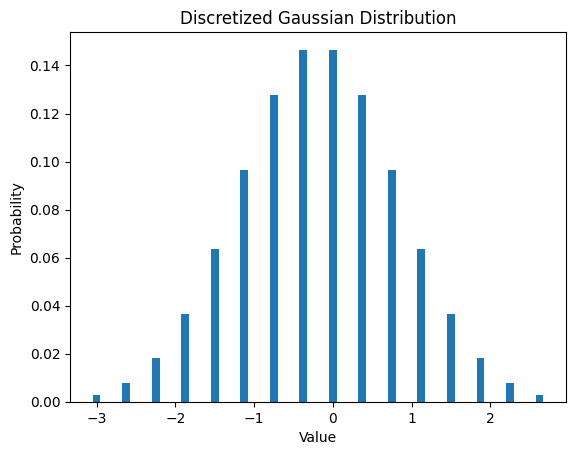

In [3]:
# plot the discretized Gaussian
import matplotlib.pyplot as plt

plt.bar(grid_points, probabilities, width=0.1)
plt.title("Discretized Gaussian Distribution")
plt.xlabel("Value")
plt.ylabel("Probability")
plt.show()

In [4]:
NUM_QUBITS_GAUSSIAN = 1
grid_points, probabilities = gaussian_discretization(NUM_QUBITS_GAUSSIAN)

## Quantum function approximation for $\sin(\pi x)$ and $2\cos(\pi x)$

For simplicity in the demo:
- Implement $\sin$ and $\cos$ via **low-order Taylor-like** polynomials (around $x=0.5$).
- This keeps the arithmetic shallow and highlights the modeling flow.

Interpretation:
- After preparing a superposition over $x$, the computed value register becomes **entangled** with $x$, representing a function evaluation “in parallel worlds.”

In [5]:
@qperm
def two_cos_pi_x(x: Const[QNum], out: Output[QNum]):
    out |= -2 * PI * (x - 0.5)  # expansion around x=0.5


@qperm
def sin_pi_x(x: Const[QNum], out: Output[QNum]):
    out |= -5 * (x - 0.5) ** 2 + 1  # expansion around x=0.5


@qfunc
def main(x: Output[QNum[3, UNSIGNED, 3]], y: Output[QNum]):
    allocate(x)
    hadamard_transform(x)
    sin_pi_x(x, y)


qprog_sin = synthesize(main)
show(qprog_sin)

Quantum program link: https://platform.classiq.io/circuit/36pwmH1ke1rrHMBPgZAYTeHFUlA


https://platform.classiq.io/circuit/36pwmH1ke1rrHMBPgZAYTeHFUlA?login=True&version=15

Let’s execute and see that x values are entangled with values of y that are a Taylor approximation
of sin around x=0.5

In [6]:
job = execute(qprog_sin)
job.open_in_ide()

Error when invoking the open external command: s is not iterable


# Chebyshev Polynomials

The Chebyshev polynomials are a sequence of orthogonal polynomials that are related to de Moivre's formula and the trigonometric functions. They are defined by the recurrence relation:

$$
U_0(x) = 1,
$$
$$
U_1(x) = 2x
$$
$$
U_{k+1}(x) = 2xU_k(x) - U_{k-1}(x)
$$

In [7]:
@qperm
def uk(two_x: Const[QNum], uk_1: Const[QNum], uk_2: Const[QNum], uk: Output[QNum]):
    uk |= two_x * uk_1 - uk_2


@qfunc
def main(x: Output[QNum[2, UNSIGNED, 2]]):
    allocate(x)
    hadamard_transform(x)
    U = [QNum(f"U{k}") for k in range(L)]
    U[0] |= 1
    U[1] |= 2 * x
    for k in range(2, L):
        uk(x, uk_1=U[k - 1], uk_2=U[k - 2], uk=U[k])


qprog_uk = synthesize(main)

Circuit scaling intuition:
- Loop depth grows as $O(L)$.
- Doubling truncation order increases gate count only **linearly** (hardware-friendly).



In [8]:
show(qprog_uk)

Quantum program link: https://platform.classiq.io/circuit/36pwmrzrsiD5dUq0bmDzlSnNiS6


https://platform.classiq.io/circuit/36pwmrzrsiD5dUq0bmDzlSnNiS6?login=True&version=15

# Brownian Motion

The Brownian motion is a stochastic process that models the random movement of particles in a fluid. The approximate solution in this context is the truncated Wiener series.

$$
B_L(t) = p_L(a,cos(t)) = a_0t+\frac{\sqrt{2}}\pi sin(\pi t)\sum_{k=0}^{L-1}\frac{a_k}k U_k(cost(\pi t))
$$

Key ingredients in the quantum model:
- Prepare registers for coefficients \(a_0,\dots,a_{L-1}\) from the discretized Gaussian distribution (amplitude loading).
- Prepare a time register \(t\) in superposition (e.g., Hadamards over a time index).
- Compute:
  - $2\cos(\pi t)$ (or a stand-in approximation)
  - $\sin(\pi t)$ (or a stand-in approximation)
  - $U_k(\cos(\pi t))$ via recurrence
- Accumulate the weighted sum to form $B_L(t)$.

In [9]:
@qfunc
def truncated_wiener_series(t: QNum, out: Output[QNum]):
    As = [QNum(f"a{i}") for i in range(L)]
    for a in As:
        prepare_state(probabilities, 0, a)

    two_cos_pi_t = QNum("two_cos_pi_t")
    sin_pi_t = QNum("sin_pi_t")
    U = [QNum(f"U{k}") for k in range(L)]

    two_cos_pi_x(x=t, out=two_cos_pi_t)
    U[0] |= 1
    U[1] |= two_cos_pi_t
    for k in range(2, L):
        uk(two_cos_pi_t, uk_1=U[k - 1], uk_2=U[k - 2], uk=U[k])

    sin_pi_x(x=t, out=sin_pi_t)

    out |= As[0] * t + (2**0.5 / PI) * sin_pi_t * sum(
        [As[i] * U[i] for i in range(1, L)]
    )

    for a in As:
        drop(a)

    for u in U:
        drop(u)

## Return-to-price space (GBM mapping)

Convert (log-)returns to price using the GBM form:
$$
S(t) = S_0 \exp\left(\sigma\,B_L(t) + \left(\mu - \frac{\sigma^2}{2}\right)t\right)
$$

In the demo notebook :
- Exponentiation may be implemented via a simple approximation for $\exp(\cdot)$.
- More accurate quantum exponentiation methods exist in the literature (see referenced suggestions in https://arxiv.org/pdf/2001.00807.pdf for example).

In [10]:
@qperm
def return_to_price_space(
    returns: Const[QNum], t: Const[QNum], price: Output[QNum]
) -> None:
    price |= (SIGMA * returns + (MU - SIGMA**2 / 2) * t) + 1

# Putting it all together

In [11]:
@qfunc
def main(t: Output[QNum], G: Output[QNum]):
    # Allocate qubits and prepare distributions
    B = QNum("B")

    allocate(TIME_STEPS, t)
    hadamard_transform(t)

    # Create the truncated wiener series
    truncated_wiener_series(t, B)

    # Return to price space
    return_to_price_space(returns=B, t=t, price=G)

    drop(B)

In [12]:
qmod = create_model(
    entry_point=main,
    constraints=Constraints(optimization_parameter="width", max_width=139),
    preferences=Preferences(transpilation_option="none"),
)
qprog = synthesize(qmod)

In [13]:
show(qprog)

Quantum program link: https://platform.classiq.io/circuit/36pwwbEYGXxJ48DEqHODvhN3UvC


https://platform.classiq.io/circuit/36pwwbEYGXxJ48DEqHODvhN3UvC?login=True&version=15

In [14]:
print(f"The number of qubits used: {qprog.data.width}")

The number of qubits used: 115


In [15]:
write_qmod(qmod, "brownian_chebyshev_polynomials")

# Final reflection and quantum roadmap

This notebook illustrates that a mathematically heavy model (KL-truncated GBM + Chebyshev recursion)
becomes circuit-light once randomness is moved into amplitudes.

Next steps toward pricing (expected payoff):

1. **Amplitude loading**: put Gaussian coefficients into superposition with
   $O\!\left(n\,\mathrm{polylog}(1/\epsilon)\right)$ gates (matching the power-of-two grid).

2. **Nested QAE (conceptually)**:
   - First QAE estimates time-averaged price along the path.
   - Second QAE wraps the payoff.
   - Query complexity can still beat classical Monte Carlo scaling.

3. **Potential shortcut** (as hinted in the reference):
   - Drop one QAE via smart time subsampling to reduce depth without extra qubits
     (constants and practical tradeoffs depend on implementation details).

Takeaway:
- The classical formula is algebraically dense, but the quantum program is highly structured,
  enabling modeling-focused development with automated circuit synthesis.
